# Импорт библиотек и данных 

In [105]:
import numpy as np
import seaborn as sns
from sklearn import metrics
import pandas as pd 
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import pandas as pd 
from sklearn.preprocessing import OneHotEncoder

In [3]:
train = pd.read_csv('titanic_train.csv')

In [4]:
test = pd.read_csv('titanic_test.csv')

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# EDA

## Данные: 

- survival - отметка выживших
- pclass - класс пассажира (1,2,3)
- sex - пол
- age - возраст
- sibsp - родственники на корабле 
- parch - родители или дети на корабле 
- ticket - номер билета
- fare - оплата проеза
- cabin - номер каюты
- embarked - порт отправления 

### Для начала выкинем ненужные столбцы из датафреймов: 
- embarked
- cabin 
- ticket
- Name

In [10]:
train = train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis = 1)
test = test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis = 1)

### Исследовательскй анализ 

Для анализа оставим всю выборку целиком, но без целевого признака, его будем изучать отдельно. 

In [16]:
data = pd.concat([train.drop('Survived', axis = 1), test])

In [17]:
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,male,22.0,1,0,7.2500
1,1,female,38.0,1,0,71.2833
2,3,female,26.0,0,0,7.9250
3,1,female,35.0,1,0,53.1000
4,3,male,35.0,0,0,8.0500


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  1309 non-null   int64  
 1   Sex     1309 non-null   object 
 2   Age     1046 non-null   float64
 3   SibSp   1309 non-null   int64  
 4   Parch   1309 non-null   int64  
 5   Fare    1308 non-null   float64
dtypes: float64(2), int64(3), object(1)
memory usage: 71.6+ KB


In [29]:
# для удобства приведем названия столбцов к новому регистру
data.columns = data.columns.str.lower()

### Пропуски и дубликаты

In [58]:
# проверим пропуски
data.isnull().sum()

pclass    0
sex       0
age       0
sibsp     0
parch     0
fare      0
dtype: int64

In [36]:
data.shape

(1309, 6)

Пропусков слишком много, чтобы выбрасывать их. Лучше всего заполнить их по медианам группы. 

In [62]:
data.groupby('sex').agg({'age':'median'})

,age
sex,
female,28.0
male,28.0


In [63]:
data.groupby('pclass').agg({'age':'median'})

,age
pclass,
1,36.0
2,28.0
3,28.0


По возрасту группы не сильно отличаются, а вот по классу - да. Имеет смысл заполнить медианой по классу. 

In [57]:
def median_for_all (dataframe, column, pclass): #функция рассчитывает медиану для разных типов данных 
    dataframe[dataframe[column]==pclass] = dataframe[dataframe[column]==pclass].fillna(dataframe.median())
    return dataframe
 
for pclass in list(data['pclass'].unique()): #для всех типов дохода цикл ставит индивидуальную медиану 
    median_for_all(data,'pclass', pclass)

In [66]:
# проверка на дубликаты
data.duplicated().sum()

0

Дубликатов довольно много, лучше их скинуть. 

In [65]:
data = data.drop_duplicates()

/Library/Python/3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


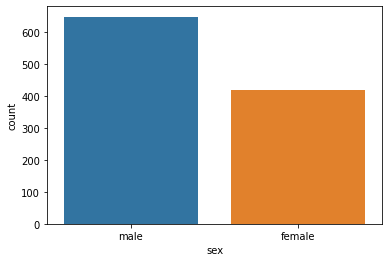

In [80]:
sns.countplot(data['sex']);

Видно, что больше на титанике присутстовало мужчин, чем женщин. Учитывая время, скорее всего много рабочих мигрантов ехали на заработки в Америку. 

/Library/Python/3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


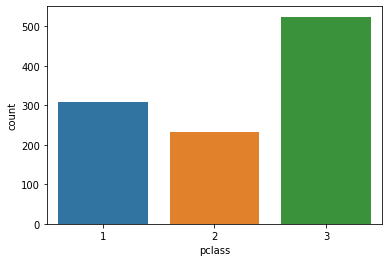

In [81]:
sns.countplot(data['pclass']);

И действительно, значительно больше людей из третьего класса присутствовало на борту, фактически - половина корабля. 

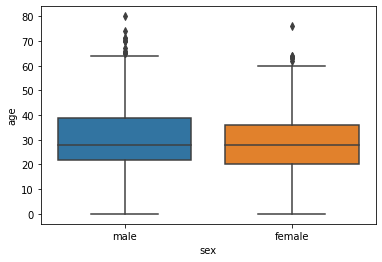

In [86]:
sns.boxplot(x = data['sex'],y = data['age']);

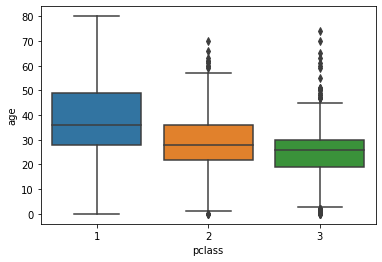

In [87]:
sns.boxplot(x = data['pclass'],y = data['age']);

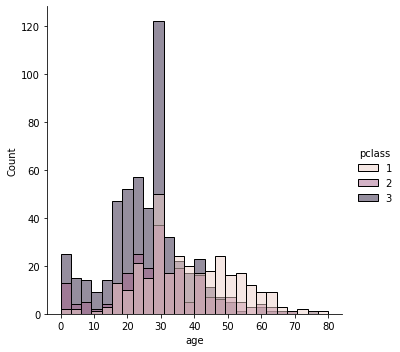

In [98]:
sns.displot(data, x =data['age'], hue = data['pclass'])

### Подробвняем типы данных

In [71]:
data.age = data.age.astype('int64')

/Library/Python/3.7/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [104]:
data.head()

,pclass,sex,age,sibsp,parch,fare
0,3,1,22,1,0,7.2500
1,1,0,38,1,0,71.2833
2,3,0,26,0,0,7.9250
3,1,0,35,1,0,53.1000
4,3,1,35,0,0,8.0500


In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1065 entries, 0 to 417
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pclass  1065 non-null   int64  
 1   sex     1065 non-null   int64  
 2   age     1065 non-null   int64  
 3   sibsp   1065 non-null   int64  
 4   parch   1065 non-null   int64  
 5   fare    1065 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 98.2 KB


In [102]:
data['sex'] = data['sex'].replace({'male':1, 'female':0})

/Library/Python/3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [110]:
pd.get_dummies(data['pclass'])

,1,2,3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1
...,...,...,...
411,1,0,0
412,0,0,1
414,1,0,0
415,0,0,1


In [114]:
data = data.drop('pclass', axis =1).join(pd.get_dummies(data['pclass']))

In [118]:
#готовые данные выглядят так
data.head()

,sex,age,sibsp,parch,fare,1,2,3
0,1,22,1,0,7.2500,0,0,1
0,1,22,1,0,7.2500,0,0,1
0,1,34,0,0,7.8292,0,0,1
0,1,34,0,0,7.8292,0,0,1
1,0,38,1,0,71.2833,1,0,0


## Подготовка выборок 

Для начала поссмотрим на интересующий нас показатель. 

/Library/Python/3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


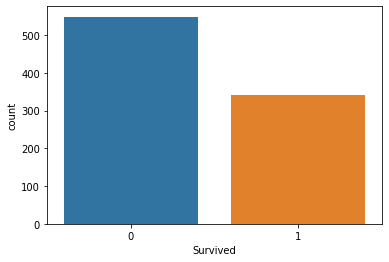

In [145]:
sns.countplot(train.Survived);

В классах есть небольшой дисбаланс, но не такой сильный, чтобы из-за этого нервничать. 

In [124]:
train.Survived.mean()

0.3838383838383838

Получается, что спаслось около 39% людей на титанике

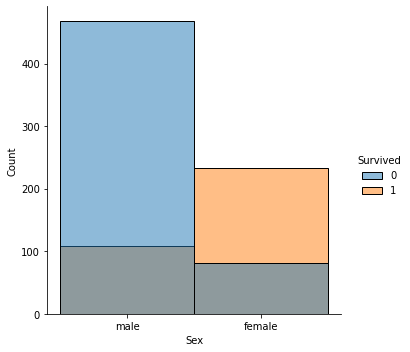

In [144]:
sns.displot(data, x = train['Sex'] , hue = train['Survived']);

In [146]:
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000
887,1,1,female,19.0,0,0,30.0000
888,0,3,female,NaN,1,2,23.4500
889,1,1,male,26.0,0,0,30.0000


In [147]:
test

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,male,34.5,0,0,7.8292
1,3,female,47.0,1,0,7.0000
2,2,male,62.0,0,0,9.6875
3,3,male,27.0,0,0,8.6625
4,3,female,22.0,1,1,12.2875
...,...,...,...,...,...,...
413,3,male,NaN,0,0,8.0500
414,1,female,39.0,0,0,108.9000
415,3,male,38.5,0,0,7.2500
416,3,male,NaN,0,0,8.0500


In [154]:
for data in [train,test]:
    data.columns = data.columns.str.lower()
    for pclass in list(data['pclass'].unique()): #для всех типов дохода цикл ставит индивидуальную медиану 
        median_for_all(data,'pclass', pclass)


In [155]:
train

,survived,pclass,sex,age,sibsp,parch,fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000
887,1,1,female,19.0,0,0,30.0000
888,0,3,female,28.0,1,2,23.4500
889,1,1,male,26.0,0,0,30.0000


In [156]:
test

,pclass,sex,age,sibsp,parch,fare
0,3,male,34.5,0,0,7.8292
1,3,female,47.0,1,0,7.0000
2,2,male,62.0,0,0,9.6875
3,3,male,27.0,0,0,8.6625
4,3,female,22.0,1,1,12.2875
...,...,...,...,...,...,...
413,3,male,27.0,0,0,8.0500
414,1,female,39.0,0,0,108.9000
415,3,male,38.5,0,0,7.2500
416,3,male,27.0,0,0,8.0500


In [163]:
for data in [train,test]:    
    data = data.drop_duplicates()
    data.age = data.age.astype('int64')
    data = data.drop('pclass', axis =1).join(pd.get_dummies(data['pclass']))


In [161]:
train['sex'] = train['sex'].replace({'male':1, 'female':0})

In [162]:
test['sex'] = test['sex'].replace({'male':1, 'female':0})

In [ ]:
data = data.drop('pclass', axis =1).join(pd.get_dummies(data['pclass']))

In [168]:
train = train.drop('pclass', axis =1).join(pd.get_dummies(train['pclass']))

In [169]:
train

,survived,sex,age,sibsp,parch,fare,1,2,3
0,0,1,22.0,1,0,7.2500,0,0,1
1,1,0,38.0,1,0,71.2833,1,0,0
2,1,0,26.0,0,0,7.9250,0,0,1
3,1,0,35.0,1,0,53.1000,1,0,0
4,0,1,35.0,0,0,8.0500,0,0,1
...,...,...,...,...,...,...,...,...,...
886,0,1,27.0,0,0,13.0000,0,1,0
887,1,0,19.0,0,0,30.0000,1,0,0
888,0,0,28.0,1,2,23.4500,0,0,1
889,1,1,26.0,0,0,30.0000,1,0,0


In [170]:
test = test.drop('pclass', axis =1).join(pd.get_dummies(test['pclass']))

In [171]:
test

,sex,age,sibsp,parch,fare,1,2,3
0,1,34.5,0,0,7.8292,0,0,1
1,0,47.0,1,0,7.0000,0,0,1
2,1,62.0,0,0,9.6875,0,1,0
3,1,27.0,0,0,8.6625,0,0,1
4,0,22.0,1,1,12.2875,0,0,1
...,...,...,...,...,...,...,...,...
413,1,27.0,0,0,8.0500,0,0,1
414,0,39.0,0,0,108.9000,1,0,0
415,1,38.5,0,0,7.2500,0,0,1
416,1,27.0,0,0,8.0500,0,0,1


## Модели

In [174]:
x_train = train.drop('survived', axis = 1)

In [175]:
y_train = train['survived']

In [176]:
x_test = test

In [185]:
rfc = RandomForestClassifier()

In [186]:
rfc.fit(x_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [187]:
rfc_pred = rfc.predict(x_test)

In [188]:
def write_to_submission_file(predicted_labels, out_file, train_num=891,
                    target='Survived', index_label="PassengerId"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(train_num + 1,
                                                  train_num + 1 +
                                                  predicted_labels.shape[0]),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [189]:
write_to_submission_file(rfc_pred, 'rfc.csv')
#0,77751

Не лучший результат. Можно попробовать его улучшить таким образом: 
- Почистить выбросы в данных по возрасту и билету
- Сбалансировать классы 